<a href="https://colab.research.google.com/github/APre203/MLTopic1/blob/main/ML_Topic2_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install librosa numpy tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import librosa
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
f1, f2, f3 = r"/content/drive/MyDrive/cv-corpus-13.0-delta-2023-03-09/en/other.tsv", r"/content/drive/MyDrive/cv-corpus-13.0-delta-2023-03-09/en/validated.tsv", r"/content/drive/MyDrive/cv-corpus-13.0-delta-2023-03-09/en/invalidated.tsv"
path = r"/content/drive/MyDrive/cv-corpus-13.0-delta-2023-03-09/en/clips/"

In [30]:
df1 = pd.read_csv(f1, sep="\t")
df2 = pd.read_csv(f2, sep="\t") #see if this is correct
df3 = pd.read_csv(f3, sep="\t") #test using this

### PreProcessing Functions

In [116]:
def mel_spectrogram(filename):
  try:
    y, sr = librosa.load(path + filename)
    window_size = 1024
    hop_length = 256

    # Calculate time_steps and frequency_bins
    time_steps = int((len(y) - window_size) / hop_length) + 1
    frequency_bins = window_size // 2

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=window_size, hop_length=hop_length)

    return mel_spectrogram
  except:
    return None
def binary_gender(name):
  if name == "male":
    return 0
  return 1

def file_to_df(csv, numb):
  df = csv.dropna(subset=["gender"])
  new_df = pd.DataFrame(columns=df.columns)  # Create an empty DataFrame

  n = 0  # Initialize a counter
  for index, row in df.iterrows():
    if n == numb:
        break  # Stop when n reaches the desired number
    spectro = mel_spectrogram(row["path"])
    if spectro is not None:

      row["spect"] = spectro
      row["bin_gender"] = binary_gender(row["gender"])

      new_df = new_df.append(row, ignore_index=True)  # Append the new row to the new DataFrame

      n += 1  # Increment the counter
  return new_df

### Model Training

In [ ]:
df1_sample = file_to_df(df1, 500) # test with 500 from other.tsv

In [119]:
width, height = 128, 128

resized_spectrograms = []


for spectrogram in df1_sample["spect"]:
    # Resizing spectrogram to the desired shape (128x128)
    resized_spectrogram = cv2.resize(spectrogram, (width, height))
    resized_spectrograms.append(resized_spectrogram)

data = np.array(resized_spectrograms)
labels = np.array(df1_sample["bin_gender"])


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [121]:

# Build a CNN model
model = models.Sequential([
    layers.Input(shape=(height, width, 1)),  # Input shape matches the resized spectrogram dimensions
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 output classes: male and female
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

model.save("/content/drive/MyDrive/model_test2.h5")

Epoch 1/10
8/8 [==============================] - 5s 486ms/step - loss: 4.1848 - accuracy: 0.7143 - val_loss: 0.4561 - val_accuracy: 0.8103
Epoch 2/10
8/8 [==============================] - 5s 678ms/step - loss: 0.2612 - accuracy: 0.9264 - val_loss: 0.5326 - val_accuracy: 0.8793
Epoch 3/10
8/8 [==============================] - 3s 394ms/step - loss: 0.1044 - accuracy: 0.9524 - val_loss: 0.4603 - val_accuracy: 0.8966
Epoch 4/10
8/8 [==============================] - 3s 392ms/step - loss: 0.0764 - accuracy: 0.9697 - val_loss: 0.4065 - val_accuracy: 0.9310
Epoch 5/10
8/8 [==============================] - 3s 377ms/step - loss: 0.0646 - accuracy: 0.9870 - val_loss: 0.3717 - val_accuracy: 0.9483
Epoch 6/10
8/8 [==============================] - 5s 680ms/step - loss: 0.0446 - accuracy: 1.0000 - val_loss: 0.3668 - val_accuracy: 0.9138
Epoch 7/10
8/8 [==============================] - 3s 397ms/step - loss: 0.0271 - accuracy: 0.9957 - val_loss: 0.3614 - val_accuracy: 0.9138
Epoch 8/10
8/8 [====

### Model Predicting

In [ ]:
df2_sample = file_to_df(df2, 1000)

In [123]:
def male_or_female(n1,n2): # 0 for male 1 for female
  if n1 > n2:
    return 0
  return 1

In [124]:
y_true = []
y_pred = []
for s, g in zip(df2_sample["spect"], df2_sample["bin_gender"]):
  width, height = 128, 128
  resized_spectrogram = cv2.resize(s, (width, height))

  prediction = model.predict(np.expand_dims(resized_spectrogram, axis=0))

  y_true.append(g)
  y_pred.append(male_or_female(prediction[0][0],prediction[0][1]))


1/1 [==============================] - 0s 30ms/step


### Confusion Matrix

In [125]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true, y_pred)

print(confusion)

[[492  39]
 [ 55 171]]


### ROC Curve

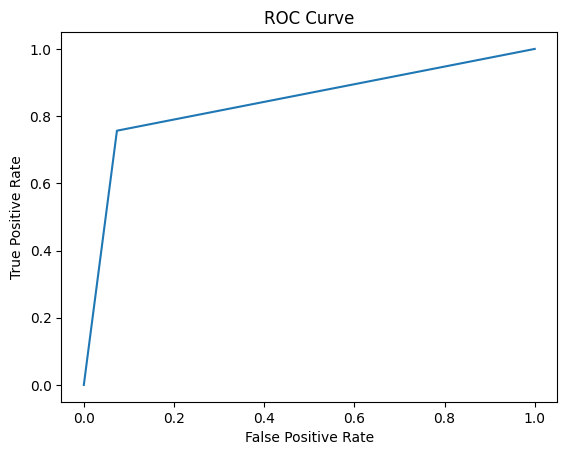

In [126]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()


In [46]:
#/content/drive/MyDrive/cv-corpus-13.0-delta-2023-03-09/en/clips